In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import OneHotEncoder
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import SGDClassifier, LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier, ExtraTreesClassifier, AdaBoostClassifier, VotingClassifier
from sklearn import tree
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, precision_score, recall_score, classification_report, f1_score
from sklearn.svm import SVC, LinearSVC
import imblearn
from collections import Counter

In [2]:
df = pd.read_excel("~/Downloads/Crunchbase_2005-2013.xls", index_col = 'Organization Name', na_values=['nan'])
eda_df = df
df.shape

(7566, 123)

# EDA

## Preprocessing for the correlation matrix(Also applicable to later modelling)

In [3]:
eda_df = eda_df[eda_df.columns[eda_df.isnull().mean() < 0.5]]
eda_df['Class'] = 0


eda_df["Last Funding Date"] = pd.DatetimeIndex(pd.to_datetime(eda_df['Last Funding Date'], unit='s')).year
eda_df["Founded Date"] = pd.DatetimeIndex(pd.to_datetime(eda_df['Founded Date'], unit='s')).year
eda_df['Acquisition Status'] = eda_df['Acquisition Status'].astype(str)
eda_df['Industry Groups'] = eda_df['Industry Groups'].astype(str)

eda_df['Estimated Revenue Range'] = eda_df['Estimated Revenue Range'].astype(str)
eda_df['Estimated Revenue Range'] = eda_df['Estimated Revenue Range'].replace('nan', np.NaN).fillna(' ')
eda_df.loc[(eda_df["Last Funding Date"] >= 2018) | (eda_df["Number of Funding Rounds"] > 7) | 
       (eda_df["IPO Status"] == "Public"),
       'Class'] = 1

/Users/aldocharles/Documents/project/env/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/Users/aldocharles/Documents/project/env/lib/python3.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """
/Users/aldocharles/Documents/project/env/lib/python3.7/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] =

## Correlation matrix for features (Filtered)

<AxesSubplot:>

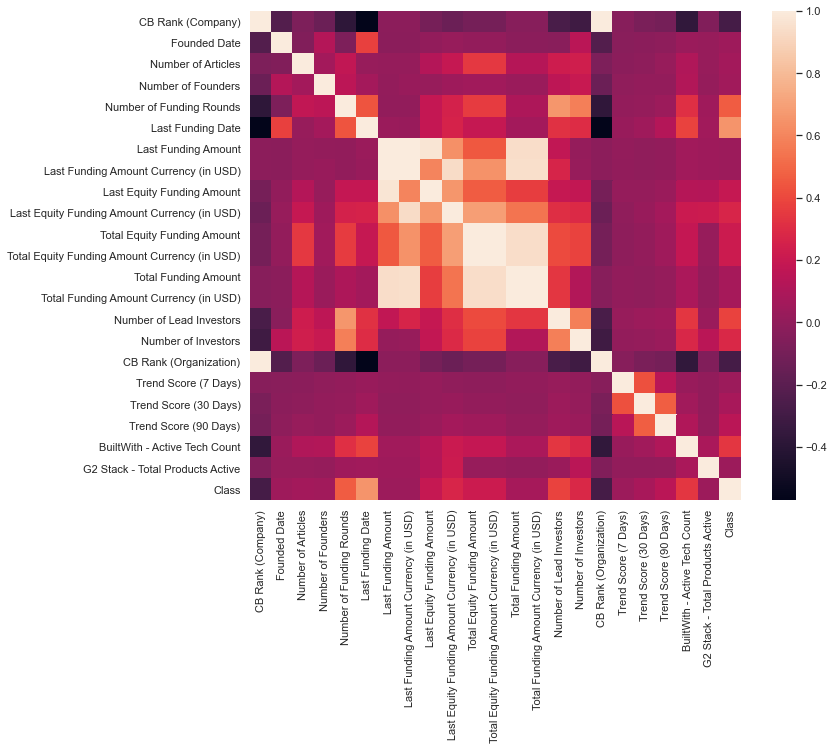

In [4]:
from string import ascii_letters
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

sns.set_theme(style="white")
corr = eda_df.corr()
mask = np.triu(np.ones_like(corr, dtype=bool))
f, ax = plt.subplots(figsize=(11, 9))
cmap = sns.diverging_palette(230, 20, as_cmap=True)
sns.heatmap(corr)

In [5]:
for i,j in eda_df.iterrows():
    loc = j['Headquarters Location'].split(',')[1]
    eda_df.loc[i,'Headquarters Location'] = j['Headquarters Location'].split(',')[1]
eda_df['Top 5 Investors'] = eda_df['Top 5 Investors'].str.split(',')
eda_df = eda_df.explode('Top 5 Investors')
eda_df['Industries'] = eda_df['Industries'].str.split(',')
eda_df = eda_df.explode('Industries')
eda_df.reset_index(inplace=True)
# eda_df.drop(['index'],axis=1,inplace=True)
eda_df=eda_df.fillna(eda_df.mode().iloc[0])

/Users/aldocharles/Documents/project/env/lib/python3.7/site-packages/pandas/core/indexing.py:1763: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(loc, value)
/Users/aldocharles/Documents/project/env/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


## Distribution of companies by location

<AxesSubplot:title={'center':'Startup frequency for cities'}>

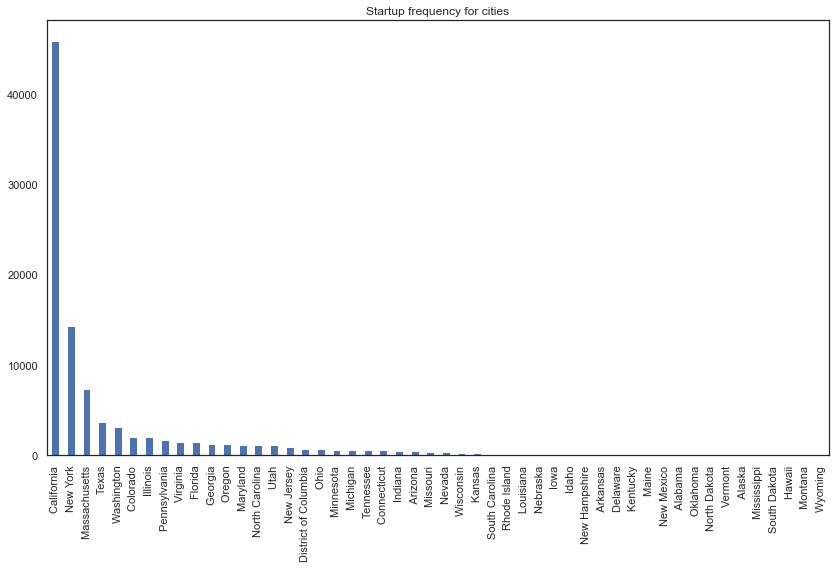

In [6]:
eda_df['Headquarters Location'].value_counts().plot(kind='bar',
                                    figsize=(14,8),
                                    title="Startup frequency for cities")

## Investors with high number of investments

In [7]:
gkk = eda_df.groupby(['Top 5 Investors'])
ee=gkk.groups
# gkk.get_group('vSpring Capital')
top_dogs = sorted(ee, key=lambda k: len(ee[k]), reverse=True)
print("Top Investors")
print(top_dogs[:5])



Top Investors
[' SV Angel', 'Techstars', ' Y Combinator', ' New Enterprise Associates', ' 500 Startups']


In [8]:
print('Sample Investment portfolio \n')
gkk.get_group(' SV Angel')

Sample Investment portfolio 



,Organization Name,Organization Name URL,Industries,Headquarters Location,Description,CB Rank (Company),Headquarters Regions,Estimated Revenue Range,Operating Status,Founded Date,...,Announced Date Precision,Acquisition Type,IPO Status,CB Rank (Organization),Trend Score (7 Days),Trend Score (30 Days),Trend Score (90 Days),BuiltWith - Active Tech Count,G2 Stack - Total Products Active,Class
863,OPKO Health,https://www.crunchbase.com/organization/opko-h...,Biotechnology,Florida,Opko Health engages in the discovery and devel...,7170,"Greater Miami Area, East Coast, Southern US",$100M to $500M,Active,2005,...,day,Acquisition,Public,7547,-0.1,4.0,-1.0,24.0,17.0,1
864,OPKO Health,https://www.crunchbase.com/organization/opko-h...,Health Diagnostics,Florida,Opko Health engages in the discovery and devel...,7170,"Greater Miami Area, East Coast, Southern US",$100M to $500M,Active,2005,...,day,Acquisition,Public,7547,-0.1,4.0,-1.0,24.0,17.0,1
865,OPKO Health,https://www.crunchbase.com/organization/opko-h...,Pharmaceutical,Florida,Opko Health engages in the discovery and devel...,7170,"Greater Miami Area, East Coast, Southern US",$100M to $500M,Active,2005,...,day,Acquisition,Public,7547,-0.1,4.0,-1.0,24.0,17.0,1
895,Practice Fusion,https://www.crunchbase.com/organization/practi...,Electronic Health Record (EHR),California,Practice Fusion provides a free web-based elec...,7923,"San Francisco Bay Area, West Coast, Western US",$100M to $500M,Active,2005,...,day,Acquisition,Private,8332,1.3,-0.3,-0.7,90.0,36.0,1
896,Practice Fusion,https://www.crunchbase.com/organization/practi...,Health Care,California,Practice Fusion provides a free web-based elec...,7923,"San Francisco Bay Area, West Coast, Western US",$100M to $500M,Active,2005,...,day,Acquisition,Private,8332,1.3,-0.3,-0.7,90.0,36.0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
97224,Walkmore (Acquired by GTE Financial),https://www.crunchbase.com/organization/walkmore,Big Data,Florida,Big data analytics for financial institutions;...,941610,"Greater Miami Area, East Coast, Southern US",,Active,2013,...,day,Acquisition,Private,994323,-0.3,-1.5,-1.9,10.0,19.0,0
97225,Walkmore (Acquired by GTE Financial),https://www.crunchbase.com/organization/walkmore,Finance,Florida,Big data analytics for financial institutions;...,941610,"Greater Miami Area, East Coast, Southern US",,Active,2013,...,day,Acquisition,Private,994323,-0.3,-1.5,-1.9,10.0,19.0,0
97226,Walkmore (Acquired by GTE Financial),https://www.crunchbase.com/organization/walkmore,Financial Services,Florida,Big data analytics for financial institutions;...,941610,"Greater Miami Area, East Coast, Southern US",,Active,2013,...,day,Acquisition,Private,994323,-0.3,-1.5,-1.9,10.0,19.0,0
97227,Walkmore (Acquired by GTE Financial),https://www.crunchbase.com/organization/walkmore,FinTech,Florida,Big data analytics for financial institutions;...,941610,"Greater Miami Area, East Coast, Southern US",,Active,2013,...,day,Acquisition,Private,994323,-0.3,-1.5,-1.9,10.0,19.0,0


## Top industries that have investments

In [9]:
print('Top 10 areas (Ignore the numbers)')
eda_df['Industries'].value_counts()[:10]

Top 10 areas (Ignore the numbers)


 Software                  6459
 Mobile                    3104
 SaaS                      2737
 Enterprise Software       2682
 Information Technology    2191
 Internet                  2064
Analytics                  2054
 Health Care               1888
Advertising                1750
Biotechnology              1377
Name: Industries, dtype: int64

## Top investors having successful investments

In [10]:

success_df = eda_df.loc[eda_df['Class']==1]
success_df = success_df.explode('Top 5 Investors')
success_df['Top 5 Investors']
success_df.reset_index(inplace=True)
success_df=success_df.fillna(success_df.mode().iloc[0])
gkk = success_df.groupby(['Top 5 Investors'])
ee=gkk.groups
top_dogs = sorted(ee, key=lambda k: len(ee[k]), reverse=True)
print("Investors with high successful investments")
print(top_dogs[:5])


Investors with high successful investments
[' SV Angel', ' Andreessen Horowitz', 'Goldman Sachs', ' New Enterprise Associates', 'Techstars']


In [11]:
for i in top_dogs[:1]:
    tem_df = success_df.loc[success_df['Top 5 Investors']==i]
    print(i,'\n')
    print(tem_df['Industries'].value_counts()[:10])
    print('\n')
    
#     ['Industries'].value_counts()[:10]

 SV Angel 

 Health Care               40
 Software                  38
Biotechnology              33
 Pharmaceutical            30
 Medical                   26
 Financial Services        23
 Information Technology    19
 Internet                  18
 Mobile                    15
Advertising                15
Name: Industries, dtype: int64




## Top industries with successful investments

In [12]:
success_df['Industries'] = success_df['Industries'].str.split(',')
success_df = success_df.explode('Industries')
success_df.reset_index(inplace=True)
# eda_df.drop(['index'],axis=1,inplace=True)
success_df=success_df.fillna(success_df.mode().iloc[0])
print("Successful industries")
success_df['Industries'].value_counts()[:10]

Successful industries


 Software                  1996
 SaaS                      1081
 Enterprise Software        868
 Information Technology     827
 Health Care                768
 Mobile                     609
Analytics                   585
Biotechnology               572
 Internet                   541
 Medical                    477
Name: Industries, dtype: int64

## Top companies under a successful investment firm( SV angel)

In [13]:
dd=gkk.get_group(' SV Angel')
aa=dd.sort_values(by=['Total Equity Funding Amount'],ascending=False)['Organization Name'][:100].to_list()
print(list(set(aa))[:10])

['AppNexus', 'Metromile', 'Credit Karma', 'Elastic', 'Pinterest', 'Vanguard Natural Resources', 'Pattern Energy Group', 'Eventbrite', 'Cresco Labs', 'Splice']


## Visualization of IPO status of successful companies

<AxesSubplot:title={'center':'IPO frequency for the successful companies'}>

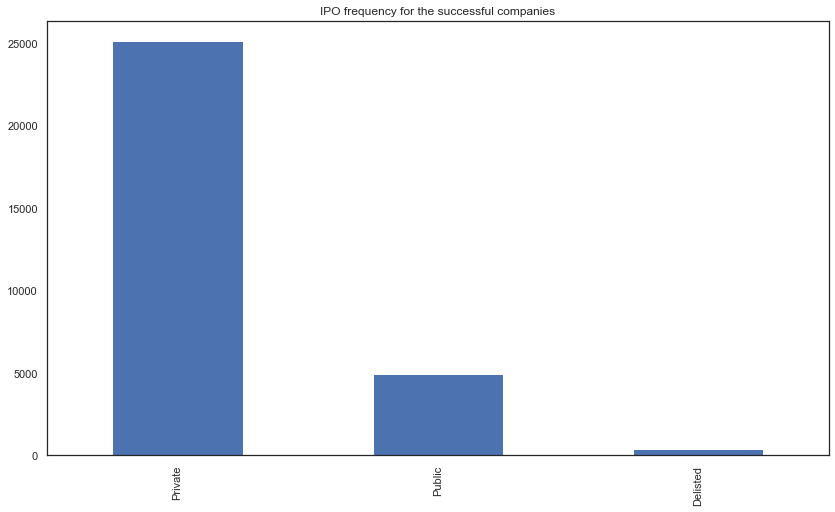

In [14]:
success_df['IPO Status'].value_counts().plot(kind='bar',
                                    figsize=(14,8),
                                    title="IPO frequency for the successful companies")

## Top Public companies with successful investments

In [15]:
private_df =success_df.loc[success_df['IPO Status']=='Public']
private_df.drop_duplicates(inplace=True)
all_comps = []
all_comps.append(private_df.sort_values(by=['Total Equity Funding Amount'],ascending=False)['Organization Name'].to_list())
# print(len(all_comps))
all_comps = list(set(all_comps[0]))
print(all_comps[:20])


['SRAX', 'New Relic', 'Credible', 'OPKO Health', 'Dermira', 'Spirit of Texas Bank', 'Veritex Bank', 'TESARO', 'Argonaut Gold', 'Franklin Synergy Bank', 'SiTime', 'QuantumScape', 'American Midstream', 'NanoSphere Health Sciences', 'NantHealth', 'Groupon', 'Conatus Pharmaceuticals', 'MiRagen', 'Nobilis Health', 'Twilio']


/Users/aldocharles/Documents/project/env/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


## Distribution of Funding type the successful companies have gone through

<AxesSubplot:title={'center':'Last Funding Type for the successful companies'}>

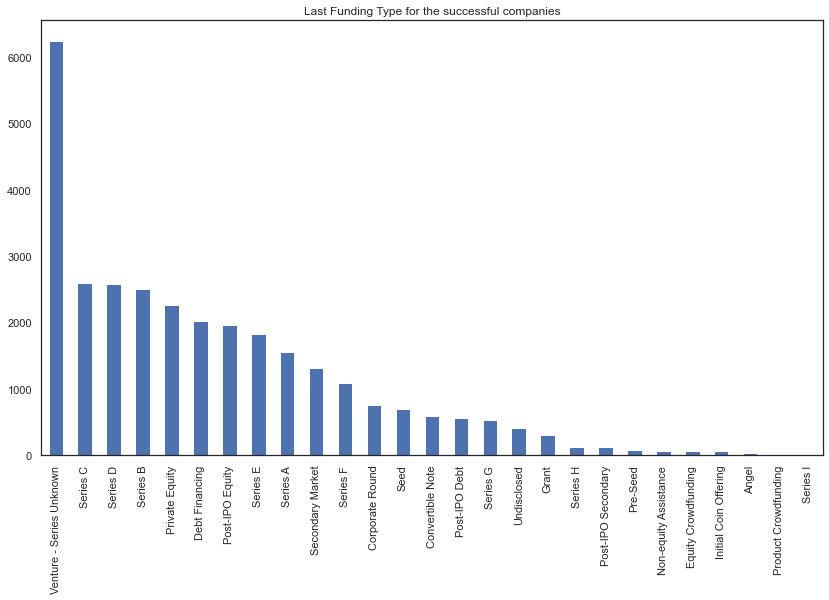

In [16]:

success_df['Last Funding Type'].value_counts().plot(kind='bar',
                                    figsize=(14,8),
                                    title="Last Funding Type for the successful companies")

## Distribution of successful companies over years

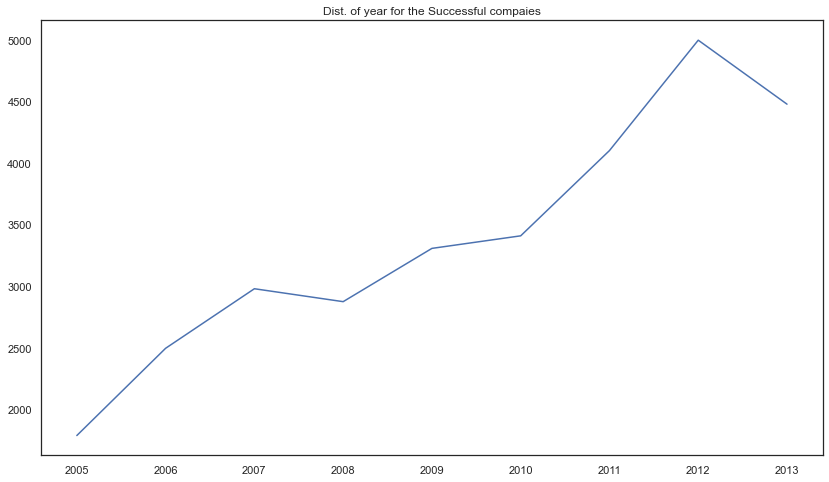

In [17]:
ax = success_df['Founded Date'].value_counts().sort_index().plot(kind='line',
                                    figsize=(14,8),
                                    title="Dist. of year for the Successful compaies")

# Data Preprocessing

In [21]:
#Decision Matrix Function
def confusion_matrix_plot(conf_mat):
    n = len(conf_mat)
    plt.imshow(conf_mat, cmap='Blues', extent=[-0.5, n-0.5, -0.5, n-0.5])
    
    for i in range(n):
        for j in range(n):
            plt.text(i, j, conf_mat[n-j-1, i], ha='center', va='center')
    
    plt.colorbar()
    plt.xticks(range(n))
    plt.yticks(range(n), range(n-1, -1, -1))
    plt.xlabel('Predicted Class')
    plt.ylabel('True Class')
    plt.plot

In [159]:
df = df[df.columns[df.isnull().mean() < 0.5]]
df.shape

(7566, 60)

In [147]:
#Drop all columns that may not be needed
column_drop = ["Phone Number", 'Full Description', 'Organization Name URL', 'Phone Number', 'Contact Email', 'LinkedIn',
       'Facebook', 'Twitter', 'Website', 'CB Rank (Organization)', 'Last Funding Amount Currency', 'Acquisition Type',
       'Last Funding Amount Currency (in USD)', 'Number of Employees', 'Number of Lead Investors', 'Number of Investors',
       'Trend Score (7 Days)', 'Trend Score (30 Days)', 'Total Equity Funding Amount Currency', 'Last Equity Funding Amount Currency',
       'Last Equity Funding Amount Currency (in USD)', 'Total Equity Funding Amount Currency', "Industries", 'CB Rank (Company)',
       'Total Equity Funding Amount Currency (in USD)', 'Total Funding Amount Currency', 'Description', "Transaction Name", 
       'Total Funding Amount Currency (in USD)', 'Exit Date Precision', 'Founded Date Precision', 'Announced Date', 'Announced Date Precision',
       'Total Equity Funding Amount Currency', 'Total Funding Amount Currency', 'Last Funding Amount Currency',
       'Trend Score (90 Days)', 'Transaction Name URL', 'Acquired by', 'Company Type',
       'Acquired by URL', 'BuiltWith - Active Tech Count', 'Number of Articles', 'Founders', 'Number of Founders',
       'G2 Stack - Total Products Active', 'Headquarters Location', 'Headquarters Regions', 'Exit Date',
        'Last Equity Funding Amount', 'Last Equity Funding Type', 'Total Equity Funding Amount','Total Funding Amount',
        'Last Funding Amount', 'Operating Status']
       
df = df.drop(axis = 1, columns = column_drop)

df.isnull().sum()

Estimated Revenue Range     2807
Founded Date                   0
Industry Groups               12
Number of Funding Rounds       0
Funding Status               512
Last Funding Date              0
Last Funding Type              0
Top 5 Investors             1060
Acquisition Status             0
IPO Status                     0
dtype: int64

In [128]:
df.dtypes

Estimated Revenue Range             object
Founded Date                datetime64[ns]
Industry Groups                     object
Number of Funding Rounds             int64
Funding Status                      object
Last Funding Date           datetime64[ns]
Last Funding Type                   object
Top 5 Investors                     object
Acquisition Status                  object
IPO Status                          object
Class                                int64
dtype: object

In [130]:
df["IPO Status"].unique()

array(['Private', 'Public', 'Delisted'], dtype=object)

In [131]:
df['Acquisition Status'].unique()

array(['Made Acquisitions', 'Made Acquisitions, Was Acquired',
       'Was Acquired'], dtype=object)

In [132]:
df["Industry Groups"].unique()

array(['Artificial Intelligence, Data and Analytics, Information Technology, Science and Engineering, Software',
       'Content and Publishing, Internet Services, Media and Entertainment, Other',
       'Administrative Services, Financial Services, Software', ...,
       'Commerce and Shopping, Events, Media and Entertainment, Other',
       'Content and Publishing, Data and Analytics, Design, Internet Services, Media and Entertainment, Software',
       'Consumer Electronics, Hardware, Information Technology'],
      dtype=object)

In [133]:
df['Estimated Revenue Range'].unique()

array(['$1B to $10B', '$100M to $500M', '$500M to $1B', '$50M to $100M',
       nan, '$10M to $50M', '$1M to $10M', 'Less than $1M', '$10B+'],
      dtype=object)

In [134]:
df.pivot_table(index=['IPO Status'], aggfunc='size')

IPO Status
Delisted     114
Private     7045
Public       407
dtype: int64

In [135]:
df.pivot_table(index=['Estimated Revenue Range'], aggfunc='size')

Estimated Revenue Range
$100M to $500M     372
$10B+                9
$10M to $50M      1312
$1B to $10B         58
$1M to $10M       2039
$500M to $1B        57
$50M to $100M      294
Less than $1M      618
dtype: int64

In [136]:
df.pivot_table(index=['Acquisition Status'], aggfunc='size')

Acquisition Status
Made Acquisitions                  1876
Made Acquisitions, Was Acquired     797
Was Acquired                       4893
dtype: int64

In [20]:
#Converting columns to the correct data type
df["Last Funding Date"] = pd.DatetimeIndex(pd.to_datetime(df['Last Funding Date'], unit='s')).year
df["Founded Date"] = pd.DatetimeIndex(pd.to_datetime(df['Founded Date'], unit='s')).year
df['Acquisition Status'] = df['Acquisition Status'].astype(str)
df['Industry Groups'] = df['Industry Groups'].astype(str)

df['Estimated Revenue Range'] = df['Estimated Revenue Range'].astype(str)
df['Estimated Revenue Range'] = df['Estimated Revenue Range'].replace('nan', np.NaN).fillna(' ')
df

,Organization Name URL,Industries,Headquarters Location,Description,CB Rank (Company),Headquarters Regions,Estimated Revenue Range,Operating Status,Founded Date,Founded Date Precision,...,Announced Date,Announced Date Precision,Acquisition Type,IPO Status,CB Rank (Organization),Trend Score (7 Days),Trend Score (30 Days),Trend Score (90 Days),BuiltWith - Active Tech Count,G2 Stack - Total Products Active
Organization Name,,,,,,,,,,,,,,,,,,,,,
UiPath,https://www.crunchbase.com/organization/uipath,"Artificial Intelligence, Enterprise Software, ...",New York,UiPath is a software company developing roboti...,34,"Greater New York Area, East Coast, Northeaster...",$1B to $10B,Active,2005,year,...,NaT,NaN,NaN,Private,40,-0.8,-2.3,5.3,159.0,63.0
Reddit,https://www.crunchbase.com/organization/reddit,"Content, News, Social Bookmarking, Social Medi...",California,Reddit is an online platform that enables user...,68,"San Francisco Bay Area, West Coast, Western US",$100M to $500M,Active,2005,year,...,2006-10-31,day,Acquisition,Private,78,-1.7,5.5,9.5,8.0,62.0
Workday,https://www.crunchbase.com/organization/workday,"Enterprise Software, Finance, FinTech, Human R...",California,Workday provides SaaS-based enterprise solutio...,103,"San Francisco Bay Area, West Coast, Western US",$1B to $10B,Active,2005,day,...,NaT,NaN,NaN,Public,115,-1.2,-2.4,8.1,55.0,75.0
Box,https://www.crunchbase.com/organization/box,"Cloud Computing, Enterprise Software, File Sha...",California,Box is an online file sharing and cloud conten...,160,"San Francisco Bay Area, Silicon Valley, West C...",$500M to $1B,Active,2005,year,...,NaT,NaN,NaN,Public,176,-1.4,8.5,8.5,80.0,91.0
Zillow,https://www.crunchbase.com/organization/zillow,"Marketplace, Online Portals, Real Estate",Washington,Zillow is an online real estate marketplace fo...,164,"Greater Seattle Area, West Coast, Western US",$500M to $1B,Active,2005,year,...,NaT,NaN,NaN,Public,180,-2.1,-1.1,7.1,85.0,72.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ActiveNet,https://www.crunchbase.com/organization/activenet,"Big Data, Data Integration, Software",Utah,ActiveNet offers a platform to integrate and s...,671934,Western US,,Active,2013,year,...,2015-01-01,day,Acquisition,Private,712487,-0.5,-0.4,-0.6,1.0,5.0
FriedWire,https://www.crunchbase.com/organization/friedwire,Analytics,Colorado,"FriedWire Inc., a recently formed Internet com...",683021,"Greater Denver Area, Western US",,Active,2013,year,...,2003-10-08,day,Acquisition,Private,724059,-0.5,-0.4,-0.1,6.0,NaN
ReferBright,https://www.crunchbase.com/organization/referb...,Health Care,California,ReferBright is the first comprehensive digital...,789401,"San Francisco Bay Area, Silicon Valley, West C...",,Active,2013,day,...,2016-03-16,day,Acquisition,Private,835050,-0.5,-0.5,0.0,7.0,NaN


## Success Metric

In [22]:
#Successfui company metric
df['Class'] = 0

df.loc[(df["Last Funding Date"] >= 2018) | (df["Number of Funding Rounds"] > 7) | 
       (df["IPO Status"] == "Public"),
       'Class'] = 1

In [131]:
#Sum should be 1804, seems like a somewhat accurate distribution
df["Class"].sum()

1804

In [26]:
#list of column values
rev_list = [x for x in df['Estimated Revenue Range'].unique() if str(x) != 'nan']
rev_list

['$1B to $10B',
 '$100M to $500M',
 '$500M to $1B',
 '$50M to $100M',
 ' ',
 '$10M to $50M',
 '$1M to $10M',
 'Less than $1M',
 '$10B+']

In [133]:
#One hot encoding cell 
enc = OneHotEncoder(sparse=False)

IPO_status = df[["IPO Status"]]
Acquisition_status = df[["Acquisition Status"]]
Estimated_Revenue = df[["Estimated Revenue Range"]]
IPO_1hot = enc.fit_transform(IPO_status)
Acquisition_status_1hot = enc.fit_transform(Acquisition_status)
Revenue_1hot = enc.fit_transform(Estimated_Revenue)
IPO_df = pd.DataFrame(columns = ['Delisted', 'Private', 'Public'], data = IPO_1hot, index = df.index)
Acquisition_df = pd.DataFrame(columns = df["Acquisition Status"].unique(), data = Acquisition_status_1hot, index = df.index)
Revenue_df = pd.DataFrame(columns = enc.get_feature_names(['Revenue']), data = Revenue_1hot, index = df.index)

In [134]:
#Add one hot dataframes to exisiting df
df = df.drop(['IPO Status', 'Acquisition Status', 'Estimated Revenue Range'], axis=1)
df = pd.concat([IPO_df, df], axis=1)
df = pd.concat([Acquisition_df, df], axis=1)
df = pd.concat([Revenue_df, df], axis=1)

In [135]:
#Possible vectorizing of industry terms
tf_idf = TfidfVectorizer(ngram_range = (1, 1), stop_words='english')

bow = tf_idf.fit_transform(df['Industry Groups']).toarray()

vect = pd.DataFrame(bow, columns=tf_idf.get_feature_names(), index=df.index)
df = pd.concat([vect, df], axis=1)

In [136]:
df.drop('Revenue_ ', axis=1, inplace=True)

In [74]:
#Select X & y then use undersampling to redistribute the data
from imblearn.under_sampling import RandomUnderSampler

X = df.iloc[:, 0:85]
y = df["Class"]

rus = RandomUnderSampler(random_state=0)
X_resampled, y_resampled = rus.fit_resample(X, y)

X_resampled.isnull().sum()

administrative                     0
advertising                        0
agriculture                        0
analytics                          0
apparel                            0
                                  ..
Made Acquisitions, Was Acquired    0
Was Acquired                       0
Delisted                           0
Private                            0
Public                             0
Length: 85, dtype: int64

In [75]:
test_precision = []
test_recall = []
training_size = []
train_size = 0.3
results = pd.DataFrame()

for i in range(17):
    X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, train_size = train_size)

    clf = SGDClassifier()
    
    clf.fit(X_train, y_train)
    y_pred_train = clf.predict(X_train)
    y_pred_test = clf.predict(X_test)
    test_precision.append(precision_score(y_test, y_pred_test))
    test_recall.append(recall_score(y_test, y_pred_test))
    training_size.append(round(train_size, 3))
    
    train_size += 0.025

results["Test Precision"] = test_precision
results["Test Recall"] = test_recall
results["Train Size"] = training_size
results
max_recall = results.loc[results["Test Recall"].idxmax()]
#print("Best Results")
max_recall

Test Precision    0.667050
Test Recall       0.912667
Train Size        0.300000
Name: 0, dtype: float64

In [76]:
test_size = (1 - max_recall["Train Size"])
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size = test_size)

# Model Creation

## Random Forest

In [77]:
final_results = pd.DataFrame(index = ["Training Accuracy", "Test Accuracy", 'Training F1 Score', "Test F1 Score"])

In [78]:
#Using random forest classifier for feature importance & overall accuracy
clf = RandomForestClassifier(oob_score = True, bootstrap=True)

clf.fit(X_train, y_train)
y_pred_train = clf.predict(X_train)
y_pred_test = clf.predict(X_test)

final_results["Random Forest"] = [clf.score(X_train, y_train), clf.score(X_test, y_test), f1_score(y_train, y_pred_train), f1_score(y_test, y_pred_test)]

Training Confusion Matrix
Training Precision: 0.9683 Training Recall: 0.9793
              precision    recall  f1-score   support

    Fail (0)       0.98      0.97      0.97       551
  Sucess (1)       0.97      0.98      0.97       531

    accuracy                           0.97      1082
   macro avg       0.97      0.97      0.97      1082
weighted avg       0.97      0.97      0.97      1082



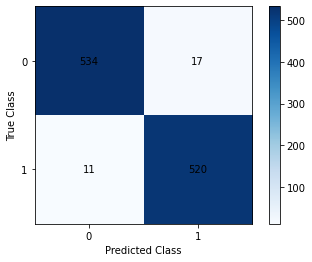

In [79]:
conf_mat_train = confusion_matrix(y_train, y_pred_train)
conf_mat_test = confusion_matrix(y_test, y_pred_test)

print("Training Confusion Matrix")
confusion_matrix_plot(conf_mat_train)
print(f"Training Precision: {round(precision_score(y_train, y_pred_train),4)} Training Recall: {round(recall_score(y_train, y_pred_train),4)}")
target_names = ['Fail (0)', 'Sucess (1)']
print(classification_report(y_train, y_pred_train, target_names=target_names))

Test Confusion Matrix
Test Precision: 0.7608 Test Recall: 0.6921
              precision    recall  f1-score   support

    Fail (0)       0.71      0.78      0.74      1253
  Sucess (1)       0.76      0.69      0.72      1273

    accuracy                           0.74      2526
   macro avg       0.74      0.74      0.73      2526
weighted avg       0.74      0.74      0.73      2526



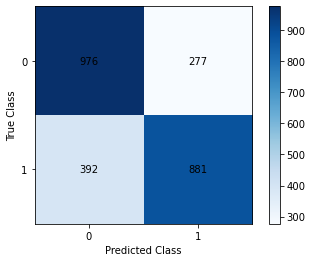

In [80]:
print("Test Confusion Matrix")
confusion_matrix_plot(conf_mat_test)
print(f"Test Precision: {round(precision_score(y_test, y_pred_test),4)} Test Recall: {round(recall_score(y_test, y_pred_test),4)}")
print(classification_report(y_test, y_pred_test, target_names=target_names))

In [81]:
#Prints the most important features
feature_importances = pd.DataFrame(clf.feature_importances_,
                                   index = X_train.columns,
                                    columns=['Importance']).sort_values('Importance', ascending=False)
print("OOB Score", clf.oob_score_)

with pd.option_context('display.max_rows', None, 'display.max_columns', None):
    print(feature_importances)

OOB Score 0.743992606284658
                                 Importance
Made Acquisitions                  0.109520
Was Acquired                       0.092526
software                           0.043322
Private                            0.039502
Public                             0.038595
Revenue_$1M to $10M                0.035276
services                           0.030450
internet                           0.025151
Revenue_$10M to $50M               0.024655
technology                         0.023005
mobile                             0.021985
Revenue_Less than $1M              0.021027
information                        0.020042
Revenue_$50M to $100M              0.019832
Revenue_$100M to $500M             0.018038
care                               0.017080
hardware                           0.016900
entertainment                      0.015727
health                             0.015650
marketing                          0.015434
media                              0.015368
sale

In [116]:
#Filter list of companies based on feature importance

private_successful_companies = df.loc[(df["Private"] == 1) & (df["Class"] == 1) & (df["Made Acquisitions"] == 1) &
                                     ((df["software"] != 0) | (df["technology"] != 0))]
private_successful_companies.index

Index(['UiPath', 'Automattic', 'Interos', 'appfire', 'Bossa Nova Robotics',
       'DialogTech', 'Nayax', 'Performive', 'RockYou', 'Persivia',
       ...
       'OrthoFi', 'Olis Robotics', 'Carely', 'sourceeasy', 'Dash Robotics',
       'Infinite Blue', 'DWS Holdings, Inc.', 'Voi', 'Kudobuzz',
       'Sleeker App Studios'],
      dtype='object', name='Organization Name', length=471)

## Neural Net

In [83]:
#Neural Net Model
from sklearn.neural_network import MLPClassifier

clf2 = MLPClassifier(hidden_layer_sizes=(100,), max_iter=50, early_stopping=True,
                    n_iter_no_change=5, verbose=10)

clf2.fit(X_train, y_train)
y_pred_train2 = clf2.predict(X_train)
y_pred_test2 = clf2.predict(X_test)

final_results["Neural Net"] = [clf2.score(X_train, y_train), clf2.score(X_test, y_test), f1_score(y_train, y_pred_train2), f1_score(y_test, y_pred_test2)]

Iteration 1, loss = 0.69674621
Validation score: 0.568807
Iteration 2, loss = 0.66971548
Validation score: 0.642202
Iteration 3, loss = 0.64582798
Validation score: 0.651376
Iteration 4, loss = 0.62436283
Validation score: 0.715596
Iteration 5, loss = 0.60353285
Validation score: 0.733945
Iteration 6, loss = 0.58511662
Validation score: 0.733945
Iteration 7, loss = 0.56724045
Validation score: 0.724771
Iteration 8, loss = 0.55073398
Validation score: 0.733945
Iteration 9, loss = 0.53613779
Validation score: 0.752294
Iteration 10, loss = 0.52259398
Validation score: 0.770642
Iteration 11, loss = 0.50969148
Validation score: 0.761468
Iteration 12, loss = 0.49976185
Validation score: 0.761468
Iteration 13, loss = 0.49013702
Validation score: 0.770642
Iteration 14, loss = 0.48215958
Validation score: 0.770642
Iteration 15, loss = 0.47521873
Validation score: 0.770642
Iteration 16, loss = 0.46957101
Validation score: 0.779817
Iteration 17, loss = 0.46394392
Validation score: 0.779817
Iterat

Training Confusion Matrix
Training Precision: 0.9683 Training Recall: 0.9793
              precision    recall  f1-score   support

    Fail (0)       0.76      0.83      0.80       551
  Sucess (1)       0.81      0.73      0.77       531

    accuracy                           0.78      1082
   macro avg       0.78      0.78      0.78      1082
weighted avg       0.78      0.78      0.78      1082



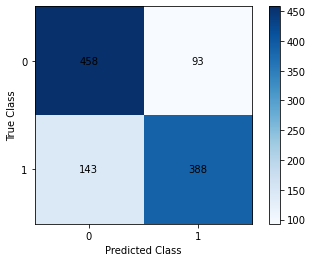

In [84]:
conf_mat_train = confusion_matrix(y_train, y_pred_train2)
conf_mat_test = confusion_matrix(y_test, y_pred_test2)

print("Training Confusion Matrix")
confusion_matrix_plot(conf_mat_train)
print(f"Training Precision: {round(precision_score(y_train, y_pred_train),4)} Training Recall: {round(recall_score(y_train, y_pred_train),4)}")
print(classification_report(y_train, y_pred_train2, target_names=target_names))

Test Confusion Matrix
Test Precision: 0.7853 Test Recall: 0.707
              precision    recall  f1-score   support

    Fail (0)       0.73      0.80      0.76      1253
  Sucess (1)       0.79      0.71      0.74      1273

    accuracy                           0.75      2526
   macro avg       0.76      0.76      0.75      2526
weighted avg       0.76      0.75      0.75      2526



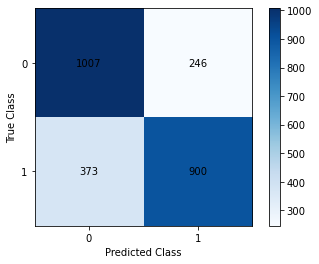

In [85]:
print("Test Confusion Matrix")
confusion_matrix_plot(conf_mat_test)
print(f"Test Precision: {round(precision_score(y_test, y_pred_test2),4)} Test Recall: {round(recall_score(y_test, y_pred_test2),4)}")
print(classification_report(y_test, y_pred_test2, target_names=target_names))

## Linear SVC

In [86]:
#LinearSVC Model
clf3 = LinearSVC(random_state=0)

clf3.fit(X_train, y_train)
y_pred_train3 = clf3.predict(X_train)
y_pred_test3 = clf3.predict(X_test)

print("Training Accuracy:", clf3.score(X_train, y_train))
print("Test Accuracy:", clf3.score(X_test, y_test))

print("Training", classification_report(y_train, y_pred_train3, target_names=target_names))
print("Test", classification_report(y_test, y_pred_test3, target_names=target_names))

final_results["LinearSVC"] = [clf3.score(X_train, y_train), clf3.score(X_test, y_test), f1_score(y_train, y_pred_train3), f1_score(y_test, y_pred_test3)]

Training Accuracy: 0.7911275415896488
Test Accuracy: 0.7640538400633412
Training               precision    recall  f1-score   support

    Fail (0)       0.78      0.82      0.80       551
  Sucess (1)       0.80      0.76      0.78       531

    accuracy                           0.79      1082
   macro avg       0.79      0.79      0.79      1082
weighted avg       0.79      0.79      0.79      1082

Test               precision    recall  f1-score   support

    Fail (0)       0.75      0.79      0.77      1253
  Sucess (1)       0.78      0.74      0.76      1273

    accuracy                           0.76      2526
   macro avg       0.76      0.76      0.76      2526
weighted avg       0.76      0.76      0.76      2526



## Logistic Regression

In [87]:
clf4  = LogisticRegression()

clf4.fit(X_train, y_train)
y_pred_train4 = clf4.predict(X_train)
y_pred_test4 = clf4.predict(X_test)

print("Training", classification_report(y_train, y_pred_train4, target_names=target_names))
print("Test", classification_report(y_test, y_pred_test4, target_names=target_names))

final_results["Logistic Regression"] = [clf4.score(X_train, y_train), clf4.score(X_test, y_test), f1_score(y_train, y_pred_train4), f1_score(y_test, y_pred_test4)]

Training               precision    recall  f1-score   support

    Fail (0)       0.77      0.83      0.80       551
  Sucess (1)       0.81      0.74      0.77       531

    accuracy                           0.79      1082
   macro avg       0.79      0.79      0.79      1082
weighted avg       0.79      0.79      0.79      1082

Test               precision    recall  f1-score   support

    Fail (0)       0.74      0.79      0.77      1253
  Sucess (1)       0.78      0.73      0.76      1273

    accuracy                           0.76      2526
   macro avg       0.76      0.76      0.76      2526
weighted avg       0.76      0.76      0.76      2526



## AdaBoost

In [88]:
clf5  = AdaBoostClassifier(n_estimators=100)

clf5.fit(X_train, y_train)
y_pred_train5 = clf5.predict(X_train)
y_pred_test5 = clf5.predict(X_test)

print("Training", classification_report(y_train, y_pred_train5, target_names=target_names))
print("Test", classification_report(y_test, y_pred_test5, target_names=target_names))

final_results["AdaBoost"] = [clf5.score(X_train, y_train), clf5.score(X_test, y_test), f1_score(y_train, y_pred_train5), f1_score(y_test, y_pred_test5)]

Training               precision    recall  f1-score   support

    Fail (0)       0.82      0.88      0.85       551
  Sucess (1)       0.86      0.80      0.83       531

    accuracy                           0.84      1082
   macro avg       0.84      0.84      0.84      1082
weighted avg       0.84      0.84      0.84      1082

Test               precision    recall  f1-score   support

    Fail (0)       0.71      0.77      0.74      1253
  Sucess (1)       0.75      0.69      0.72      1273

    accuracy                           0.73      2526
   macro avg       0.73      0.73      0.73      2526
weighted avg       0.73      0.73      0.73      2526



## Gradient Boost

In [89]:
clf6  = GradientBoostingClassifier(n_estimators=100, learning_rate=1, max_depth=1, random_state=0)

clf6.fit(X_train, y_train)
y_pred_train6 = clf6.predict(X_train)
y_pred_test6 = clf6.predict(X_test)

print("Training", classification_report(y_train, y_pred_train6, target_names=target_names))
print("Test", classification_report(y_test, y_pred_test6, target_names=target_names))

final_results["Gradient Boost"] = [clf6.score(X_train, y_train), clf6.score(X_test, y_test), f1_score(y_train, y_pred_train6), f1_score(y_test, y_pred_test6)]

Training               precision    recall  f1-score   support

    Fail (0)       0.83      0.87      0.85       551
  Sucess (1)       0.86      0.81      0.83       531

    accuracy                           0.84      1082
   macro avg       0.84      0.84      0.84      1082
weighted avg       0.84      0.84      0.84      1082

Test               precision    recall  f1-score   support

    Fail (0)       0.71      0.77      0.74      1253
  Sucess (1)       0.75      0.70      0.72      1273

    accuracy                           0.73      2526
   macro avg       0.73      0.73      0.73      2526
weighted avg       0.73      0.73      0.73      2526



## KNN

In [90]:
clf7  = KNeighborsClassifier(n_neighbors=7)

clf7.fit(X_train, y_train)
y_pred_train7 = clf7.predict(X_train)
y_pred_test7 = clf7.predict(X_test)

print("Training", classification_report(y_train, y_pred_train7, target_names=target_names))
print("Test", classification_report(y_test, y_pred_test7, target_names=target_names))

final_results["KNN"] = [clf7.score(X_train, y_train), clf7.score(X_test, y_test), f1_score(y_train, y_pred_train7), f1_score(y_test, y_pred_test7)]

Training               precision    recall  f1-score   support

    Fail (0)       0.79      0.80      0.80       551
  Sucess (1)       0.79      0.78      0.79       531

    accuracy                           0.79      1082
   macro avg       0.79      0.79      0.79      1082
weighted avg       0.79      0.79      0.79      1082

Test               precision    recall  f1-score   support

    Fail (0)       0.72      0.75      0.74      1253
  Sucess (1)       0.75      0.72      0.73      1273

    accuracy                           0.73      2526
   macro avg       0.74      0.73      0.73      2526
weighted avg       0.74      0.73      0.73      2526



## Hard Voting

In [94]:
eclf = VotingClassifier(
    estimators=[('rf', clf),('nn', clf2),('svc',clf3),('lr',clf4),('ada',clf5),('gb',clf6),('knn',clf7)],
    voting='hard')

eclf.fit(X_train, y_train)
y_pred_train8 = eclf.predict(X_train)
y_pred_test8 = eclf.predict(X_test)

print("Training", classification_report(y_train, y_pred_train8, target_names=target_names))
print("Test", classification_report(y_test, y_pred_test8, target_names=target_names))

final_results["Ensemble Hard Voting"] = [eclf.score(X_train, y_train), eclf.score(X_test, y_test), f1_score(y_train, y_pred_train8), f1_score(y_test, y_pred_test8)]

Iteration 1, loss = 0.67957190
Validation score: 0.596330
Iteration 2, loss = 0.65557776
Validation score: 0.733945
Iteration 3, loss = 0.63412146
Validation score: 0.816514
Iteration 4, loss = 0.61403972
Validation score: 0.853211
Iteration 5, loss = 0.59617841
Validation score: 0.853211
Iteration 6, loss = 0.57908287
Validation score: 0.853211
Iteration 7, loss = 0.56265434
Validation score: 0.853211
Iteration 8, loss = 0.54789950
Validation score: 0.853211
Iteration 9, loss = 0.53403102
Validation score: 0.853211
Iteration 10, loss = 0.52178208
Validation score: 0.844037
Validation score did not improve more than tol=0.000100 for 5 consecutive epochs. Stopping.
Training               precision    recall  f1-score   support

    Fail (0)       0.81      0.86      0.83       551
  Sucess (1)       0.84      0.79      0.82       531

    accuracy                           0.82      1082
   macro avg       0.83      0.82      0.82      1082
weighted avg       0.83      0.82      0.82   

## Soft Voting

In [95]:
#linearsvc cant predict probabilities
eclf2 = VotingClassifier(
    estimators=[('rf', clf),('nn', clf2),('lr',clf4),('ada',clf5),('gb',clf6),('knn',clf7)],
    voting='soft')

eclf2.fit(X_train, y_train)
y_pred_train9 = eclf2.predict(X_train)
y_pred_test9 = eclf2.predict(X_test)

print("Training", classification_report(y_train, y_pred_train9, target_names=target_names))
print("Test", classification_report(y_test, y_pred_test9, target_names=target_names))

final_results["Ensemble Soft Voting"] = [clf.score(X_train, y_train), clf.score(X_test, y_test), f1_score(y_train, y_pred_train9), f1_score(y_test, y_pred_test9)]

Iteration 1, loss = 0.69960184
Validation score: 0.642202
Iteration 2, loss = 0.67421608
Validation score: 0.688073
Iteration 3, loss = 0.65131816
Validation score: 0.706422
Iteration 4, loss = 0.62953137
Validation score: 0.724771
Iteration 5, loss = 0.60907457
Validation score: 0.743119
Iteration 6, loss = 0.58964868
Validation score: 0.743119
Iteration 7, loss = 0.57083428
Validation score: 0.752294
Iteration 8, loss = 0.55273096
Validation score: 0.752294
Iteration 9, loss = 0.53712921
Validation score: 0.752294
Iteration 10, loss = 0.52108037
Validation score: 0.752294
Iteration 11, loss = 0.50798600
Validation score: 0.752294
Iteration 12, loss = 0.49593380
Validation score: 0.752294
Iteration 13, loss = 0.48523470
Validation score: 0.752294
Validation score did not improve more than tol=0.000100 for 5 consecutive epochs. Stopping.
Training               precision    recall  f1-score   support

    Fail (0)       0.86      0.88      0.87       551
  Sucess (1)       0.87      0.8

In [96]:
final_results

,Random Forest,Neural Net,LinearSVC,Logistic Regression,AdaBoost,Gradient Boost,KNN,Ensemble Soft Voting,Ensemble Hard Voting
Training Accuracy,0.974122,0.781885,0.791128,0.786506,0.839187,0.842884,0.792052,0.974122,0.824399
Test Accuracy,0.735154,0.754949,0.764054,0.762074,0.730800,0.730800,0.734759,0.735154,0.759303
Training F1 Score,0.973783,0.766798,0.781008,0.772861,0.830078,0.834951,0.787133,0.862298,0.815534
Test F1 Score,0.724805,0.744109,0.759871,0.755592,0.721540,0.722675,0.732000,0.752212,0.751431


# Testing on New Data

### LinearSVC

In [110]:
hf = df[-15:]
hf

,administrative,advertising,agriculture,analytics,apparel,apps,artificial,audio,beverage,biotechnology,...,Private,Public,Founded Date,Industry Groups,Number of Funding Rounds,Funding Status,Last Funding Date,Last Funding Type,Top 5 Investors,Class
Organization Name,,,,,,,,,,,,,,,,,,,,,
Manage My Co-op,0.0,0.000000,0.0,0.000000,0.0,0.00000,0.0,0.0,0.0,0.0,...,1.0,0.0,2013,nan,1,M&A,2014,Seed,,0
VerbalCare,0.0,0.000000,0.0,0.000000,0.0,0.00000,0.0,0.0,0.0,0.0,...,1.0,0.0,2013,"Health Care, Information Technology, Software",1,M&A,2013,Grant,,0
RealTargeting,0.0,0.567423,0.0,0.000000,0.0,0.00000,0.0,0.0,0.0,0.0,...,1.0,0.0,2013,"Advertising, Internet Services, Sales and Mark...",1,M&A,2013,Seed,,0
Sleeker App Studios,0.0,0.000000,0.0,0.000000,0.0,0.73796,0.0,0.0,0.0,0.0,...,1.0,0.0,2013,"Apps, Mobile, Software",2,Private Equity,2018,Private Equity,,1
ProMD,0.0,0.000000,0.0,0.000000,0.0,0.63846,0.0,0.0,0.0,0.0,...,1.0,0.0,2013,"Apps, Health Care, Software",2,M&A,2014,Seed,,0
CloudPress,0.0,0.505051,0.0,0.407692,0.0,0.00000,0.0,0.0,0.0,0.0,...,1.0,0.0,2013,"Advertising, Data and Analytics, Sales and Mar...",1,M&A,2013,Non-equity Assistance,,0
HybridSite Web Services,0.0,0.000000,0.0,0.300154,0.0,0.00000,0.0,0.0,0.0,0.0,...,1.0,0.0,2013,"Content and Publishing, Data and Analytics, De...",1,M&A,2013,Seed,,0
Levy Acquisition,0.0,0.000000,0.0,0.000000,0.0,0.00000,0.0,0.0,0.0,0.0,...,1.0,0.0,2013,"Financial Services, Lending and Investments",1,Seed,2013,Seed,,0
Domain Media,0.0,0.482867,0.0,0.000000,0.0,0.00000,0.0,0.0,0.0,0.0,...,1.0,0.0,2013,"Advertising, Internet Services, Media and Ente...",1,NaN,2014,Equity Crowdfunding,[ ],0


In [111]:
X = df.iloc[:-15, 0:85]
y = df["Class"]
y = y.iloc[:-15]

Xh = hf.iloc[:, 0:85]
yh = hf["Class"]

#LinearSVC Model
clfh = LinearSVC(random_state=0)

clfh.fit(X, y)
y_pred_trainh = clfh.predict(X)
y_pred_testh = clfh.predict(Xh)

print("Training Accuracy:", clfh.score(X, y))
print("Test Accuracy:", clfh.score(Xh, yh))

print("Training", classification_report(y, y_pred_trainh, target_names=target_names))
print("Test", classification_report(yh, y_pred_testh, target_names=target_names))

Training Accuracy: 0.8396238908753807
Test Accuracy: 0.9333333333333333
Training               precision    recall  f1-score   support

    Fail (0)       0.85      0.96      0.90      5748
  Sucess (1)       0.77      0.47      0.58      1803

    accuracy                           0.84      7551
   macro avg       0.81      0.71      0.74      7551
weighted avg       0.83      0.84      0.82      7551

Test               precision    recall  f1-score   support

    Fail (0)       0.93      1.00      0.97        14
  Sucess (1)       0.00      0.00      0.00         1

    accuracy                           0.93        15
   macro avg       0.47      0.50      0.48        15
weighted avg       0.87      0.93      0.90        15



/Users/colecrescas/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/colecrescas/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/colecrescas/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [112]:
hf['predicted_full'] = y_pred_testh
hf['predicted_training'] = clf3.predict(Xh)
hf

<ipython-input-112-7e5310c658f1>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  hf['predicted_full'] = y_pred_testh
<ipython-input-112-7e5310c658f1>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  hf['predicted_training'] = clf3.predict(Xh)


,administrative,advertising,agriculture,analytics,apparel,apps,artificial,audio,beverage,biotechnology,...,Founded Date,Industry Groups,Number of Funding Rounds,Funding Status,Last Funding Date,Last Funding Type,Top 5 Investors,Class,predicted_full,predicted_training
Organization Name,,,,,,,,,,,,,,,,,,,,,
Manage My Co-op,0.0,0.000000,0.0,0.000000,0.0,0.00000,0.0,0.0,0.0,0.0,...,2013,nan,1,M&A,2014,Seed,,0,0,0
VerbalCare,0.0,0.000000,0.0,0.000000,0.0,0.00000,0.0,0.0,0.0,0.0,...,2013,"Health Care, Information Technology, Software",1,M&A,2013,Grant,,0,0,1
RealTargeting,0.0,0.567423,0.0,0.000000,0.0,0.00000,0.0,0.0,0.0,0.0,...,2013,"Advertising, Internet Services, Sales and Mark...",1,M&A,2013,Seed,,0,0,0
Sleeker App Studios,0.0,0.000000,0.0,0.000000,0.0,0.73796,0.0,0.0,0.0,0.0,...,2013,"Apps, Mobile, Software",2,Private Equity,2018,Private Equity,,1,0,1
ProMD,0.0,0.000000,0.0,0.000000,0.0,0.63846,0.0,0.0,0.0,0.0,...,2013,"Apps, Health Care, Software",2,M&A,2014,Seed,,0,0,0
CloudPress,0.0,0.505051,0.0,0.407692,0.0,0.00000,0.0,0.0,0.0,0.0,...,2013,"Advertising, Data and Analytics, Sales and Mar...",1,M&A,2013,Non-equity Assistance,,0,0,0
HybridSite Web Services,0.0,0.000000,0.0,0.300154,0.0,0.00000,0.0,0.0,0.0,0.0,...,2013,"Content and Publishing, Data and Analytics, De...",1,M&A,2013,Seed,,0,0,0
Levy Acquisition,0.0,0.000000,0.0,0.000000,0.0,0.00000,0.0,0.0,0.0,0.0,...,2013,"Financial Services, Lending and Investments",1,Seed,2013,Seed,,0,0,0
Domain Media,0.0,0.482867,0.0,0.000000,0.0,0.00000,0.0,0.0,0.0,0.0,...,2013,"Advertising, Internet Services, Media and Ente...",1,NaN,2014,Equity Crowdfunding,[ ],0,0,1
